# Swiss National Bank Balance Sheet Data Analysis

This notebook analyzes the balance sheet data from the **Swiss National Bank (SNB)**.  
The dataset has been preprocessed and pivoted for analysis and contains monthly financial values in **million CHF** (Swiss Francs).
### Soubhi SAAD - Data Analyst/Scientist
### 📂 Dataset Summary

- **Source:** SNB official data : https://data.snb.ch/en/topics/snb/cube/snbbipo?fromDate=1996-01
- **Access Method:** Retrieved programmatically via **API**
- **File:** `SNB_DATA_1.csv`
- **Time Span:** Monthly records from 1996 onward
- **Format:** Wide format (pivoted)
- **Date Column:** `Date` (parsed as datetime)
- **Columns:** Each column represents a **financial position** from the SNB balance sheet, such as:
  - `Banknotes in circulation`
  - `Foreign currency investments`
  - `Gold holdings`
  - `Liabilities towards the Confederation`
  - *...and more*

### ⚙️ Preprocessing Steps Done
- Converted `Date` to datetime
- Pivoted data: each `Position` is a column
- Filled missing values with 0
- Used `;` as CSV separator (Swiss format)
- Ensured UTF-8 encoding for compatibility

---

This notebook is now ready for:
- Time series visualization
- Trend and seasonality analysis
- Forecasting selected positions
- Correlation or anomaly detection


In [38]:
import requests
import pandas as pd
from io import StringIO

# SNB raw data CSV endpoint
url = "https://data.snb.ch/api/cube/snbbipo/data/csv/en"

# Step 1: Fetch the data
response = requests.get(url)
if response.status_code != 200:
    raise Exception(f"Failed to fetch data: {response.status_code}")

# Step 2: Split into lines
lines = response.text.splitlines()

# Step 3: Find the actual header (this time it's "Date";"D0";"Value")
header_index = None
for i, line in enumerate(lines):
    if "Date" in line and "Value" in line and "D0" in line:
        header_index = i
        break

if header_index is None:
    raise ValueError("Could not find the CSV header line.")

# Step 4: Read the actual data from that point
clean_csv = "\n".join(lines[header_index:])
df = pd.read_csv(StringIO(clean_csv), delimiter=';')

# Step 5: Clean and preview
df.columns = [col.strip('"') for col in df.columns]  # Remove quotes from column names
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

print("✅ Data loaded successfully:\n")
print(df.head())


✅ Data loaded successfully:

        Date    D0    Value
0 1996-12-01   GFG  11903.9
1 1996-12-01     D  49328.4
2 1996-12-01  RIWF   2067.8
3 1996-12-01    IZ    290.0
4 1996-12-01     W    204.3


Below is an easier version of the API request

In [39]:
import pandas as pd, requests
from io import StringIO

r = requests.get("https://data.snb.ch/api/cube/snbbipo/data/csv/en")
r.raise_for_status()

lines = r.text.splitlines()
df = pd.read_csv(StringIO("\n".join(lines[next(i for i, l in enumerate(lines) if "Date" in l and "Value" in l and "D0" in l):])), delimiter=';')

df.columns = df.columns.str.strip('"')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

print(df.head())


        Date    D0    Value
0 1996-12-01   GFG  11903.9
1 1996-12-01     D  49328.4
2 1996-12-01  RIWF   2067.8
3 1996-12-01    IZ    290.0
4 1996-12-01     W    204.3


In [40]:
df

,Date,D0,Value
0,1996-12-01,GFG,11903.900000
1,1996-12-01,D,49328.400000
2,1996-12-01,RIWF,2067.800000
3,1996-12-01,IZ,290.000000
4,1996-12-01,W,204.300000
...,...,...,...
9543,2025-04-01,VF,30416.473616
9544,2025-04-01,AIWFS,9864.649547
9545,2025-04-01,SP,106.279986
9546,2025-04-01,RE,117741.237094


In [42]:
# Step 6: Rename columns for clarity
df.columns = ["Date", "Code", "Value"]

In [43]:
# step 7: Convert 'Date' to datetime format
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


In [44]:
# step 8: Create a mapping for the codes to their descriptions
code_to_label = {
    "GFG": "Gold holdings and claims from gold transactions",
    "D": "Foreign currency investments",
    "RIWF": "Reserve position in the IMF",
    "IZ": "International payment instruments",
    "W": "Monetary assistance loans",
    "FRGSF": "Claims from CHF repo transactions",
    "FRGUSD": "Claims from USD repo transactions",
    "GSGSF": "Balances from swap transactions against CHF",
    "IG": "Domestic money market claims",
    "GD": "Secured loans",
    "FI": "Amounts due from domestic correspondents",
    "WSF": "CHF securities",
    "DS": "Loan to stabilisation fund",
    "UA": "Other assets",
    "T0": "Total assets",
    "N": "Banknotes in circulation",
    "GB": "Sight deposits of domestic banks",
    "VB": "Amounts due to the Confederation",
    "GBI": "Sight deposits of foreign banks and institutions",
    "US": "Other sight liabilities",
    "VRGSF": "Liabilities from CHF repo transactions",
    "ES": "SNB debt certificates",
    "UT": "Other time liabilities",
    "VF": "Foreign currency liabilities",
    "AIWFS": "IMF SDR counterpart",
    "SP": "Other liabilities",
    "RE": "Provisions and equity capital",
    "T1": "Total liabilities"
}

df["Position"] = df["Code"].map(code_to_label)


In [45]:
df.isna().sum()  # Check for any missing codes


Date           0
Code           0
Value       1173
Position       0
dtype: int64

In [49]:
df[df["Value"].isna()] # Display rows with missing values in 'Value' column


,Date,Code,Value,Position
5,1996-12-01,FRGSF,NaN,Claims from CHF repo transactions
6,1996-12-01,FRGUSD,NaN,Claims from USD repo transactions
7,1996-12-01,GSGSF,NaN,Balances from swap transactions against CHF
9,1996-12-01,GD,NaN,Secured loans
12,1996-12-01,DS,NaN,Loan to stabilisation fund
...,...,...,...,...
9416,2024-12-01,IG,NaN,Domestic money market claims
9444,2025-01-01,IG,NaN,Domestic money market claims
9472,2025-02-01,IG,NaN,Domestic money market claims
9500,2025-03-01,IG,NaN,Domestic money market claims


In [50]:
# count missing values by code
missing_by_code = df[df["Value"].isna()].groupby("Code").size().sort_values(ascending=False)
print(missing_by_code)


Code
IG        317
AIWFS     152
DS        144
ES        142
GSGSF     142
FRGUSD    132
GD         88
VF         24
FRGSF      16
VRGSF      16
dtype: int64


<Axes: title={'center': 'Top 10 Codes with Missing Values'}, ylabel='Code'>

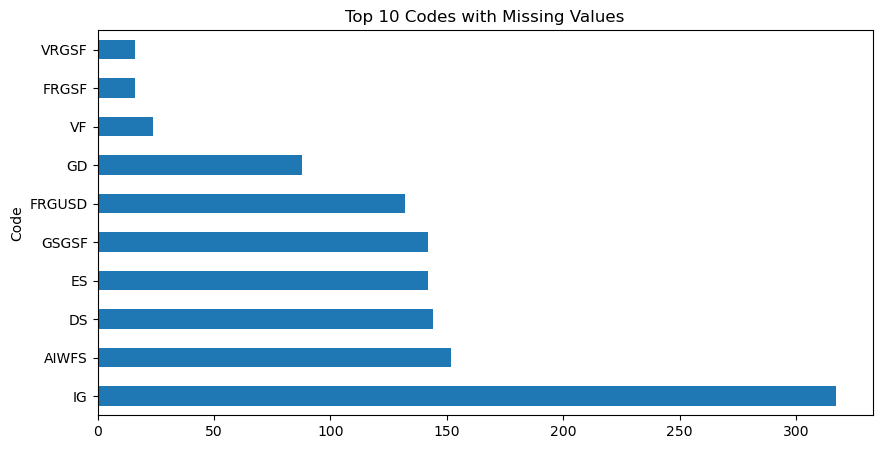

In [52]:
# plotting the top 10 codes with missing values to have a visual representation
missing_by_code.head(10).plot(kind='barh', title='Top 10 Codes with Missing Values', figsize=(10,5))


In [54]:
df["Value"] = df["Value"].fillna(0) # Fill missing values with 0


In [55]:
df.isna().sum()  # Check for any missing codes

Date        0
Code        0
Value       0
Position    0
dtype: int64

In [57]:
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")
#df.drop_duplicates(inplace=True)

Duplicate rows: 0


In [60]:
df.dtypes

Date        datetime64[ns]
Code                object
Value              float64
Position            object
dtype: object

In [69]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Pivot data: each Position becomes a column (Date stays as a column after reset_index)
df_pivot = df.pivot(index='Date', columns='Position', values='Value')

# Reset index to move 'Date' back as a column and restore integer index
df_pivot = df_pivot.reset_index()

# Fill missing values with 0 (optional, depending on analysis)
df_pivot = df_pivot.fillna(0)

# Preview the result
df_pivot.head()


Position,Date,Amounts due from domestic correspondents,Amounts due to the Confederation,Balances from swap transactions against CHF,Banknotes in circulation,CHF securities,Claims from CHF repo transactions,Claims from USD repo transactions,Domestic money market claims,Foreign currency investments,...,Other sight liabilities,Other time liabilities,Provisions and equity capital,Reserve position in the IMF,SNB debt certificates,Secured loans,Sight deposits of domestic banks,Sight deposits of foreign banks and institutions,Total assets,Total liabilities
0,1996-12-01,514.5,1654.8,0.0,32447.6,4821.5,0.0,0.0,1581.7,49328.4,...,204.1,0.0,31104.6,2067.8,0.0,0.0,4927.383264,32.7,72526.1,72526.1
1,1997-01-01,364.0,1585.6,0.0,29656.0,4818.9,0.0,0.0,282.6,47263.3,...,230.1,0.0,31104.6,2068.0,0.0,0.0,3493.574059,38.1,68322.2,68322.2
2,1997-02-01,132.6,1677.5,0.0,29508.4,4811.7,0.0,0.0,1633.9,46147.1,...,197.9,0.0,31104.6,1999.0,0.0,0.0,3456.773730,58.5,68351.1,68351.1
3,1997-03-01,175.9,1542.8,0.0,29986.4,4832.1,0.0,0.0,1762.8,48885.0,...,208.1,0.0,31115.5,2043.8,0.0,0.0,3853.681870,51.1,71261.3,71261.3
4,1997-04-01,352.0,1919.1,0.0,29273.2,4831.0,0.0,0.0,645.3,48188.3,...,182.3,0.0,31116.5,2043.9,0.0,0.0,3185.988955,70.9,69906.8,69906.8


In [73]:

# Step 9: Export the pivoted DataFrame to CSV with specific formatting
df_export = df_pivot.copy()

float_cols = df_export.select_dtypes(include='float').columns
df_export[float_cols] = df_export[float_cols].applymap(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

df_export.to_csv("SNB_DATA_1.csv", index=False, sep=';', encoding='utf-8')


C:\Users\soubh\AppData\Local\Temp\ipykernel_29188\2008115783.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_export[float_cols] = df_export[float_cols].applymap(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))


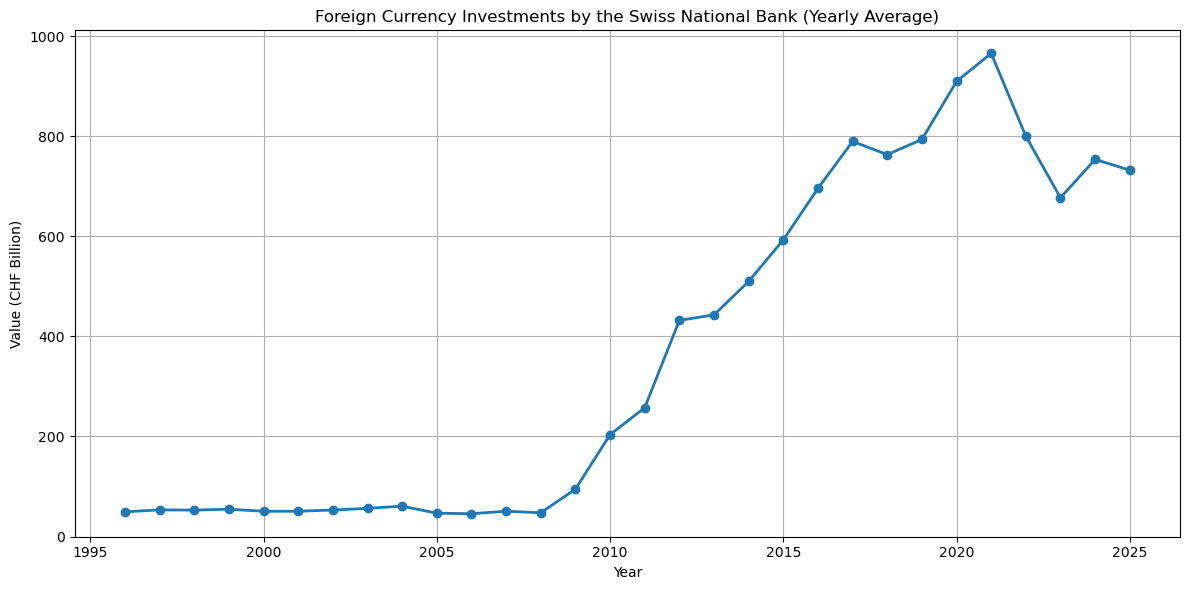

In [58]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
df_fx = df[df["Code"] == "D"].copy()
df_fx["Date"] = pd.to_datetime(df_fx["Date"])
df_fx["Year"] = df_fx["Date"].dt.year

# Group by year and get the average or last value
df_fx_yearly = df_fx.groupby("Year").last().reset_index()

# Convert to billions
df_fx_yearly["Value_Billion"] = df_fx_yearly["Value"] / 1_000

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_fx_yearly["Year"], df_fx_yearly["Value_Billion"], marker='o', linewidth=2)

plt.title("Foreign Currency Investments by the Swiss National Bank (Yearly Average)")
plt.xlabel("Year")
plt.ylabel("Value (CHF Billion)")
plt.grid(True)
plt.tight_layout()
plt.show()
